In [1]:

from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

c:\Users\USER\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
llm = ChatGoogleGenerativeAI(model= "gemini-2.5-flash")
llm_with_tools = llm.bind_tools(tools = tools)

In [3]:
def agent(state: ChildState):
    return {
        "messages" : [llm_with_tools.invoke(state["messages"])],
    }

In [4]:
def tool_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END

In [5]:
tool_node = ToolNode(tools=tools)
subgraph = StateGraph(ChildState)
subgraph.add_node("agent",agent)
subgraph.add_node("tool_node",tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent",tool_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

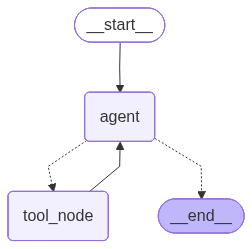

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(search_app.get_graph(xray=True).draw_mermaid_png())) 

In [7]:

search_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='e66be21d-cf6d-46c6-8f52-13cf339342c1'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Chennai"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--788f7bfa-8e0f-41e5-8a51-42344871bdb6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Chennai'}, 'id': 'f09622d1-2ae9-41ff-9eea-0ebc239b1ab5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 81, 'output_tokens': 23, 'total_tokens': 159, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"url": "https://timesofindia.indiatimes.com/city/chennai/chennai-weather-update-warmth-light-rain-and-air-quality-insights-for-september-27-2025/articleshow/124174205.cms", "content": "The data for this weat

### Case 1: shared same schema(Direct Embedding)

In [8]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

In [10]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
result

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='dcb3187c-fb6e-41a2-b47c-e00af26a6f8a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Chennai"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--ed4fa2a6-5d73-4fd3-8ef5-f85cdbe9dc2d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Chennai'}, 'id': 'e0908bd0-dc32-4a7f-a02c-5431dfb21e88', 'type': 'tool_call'}], usage_metadata={'input_tokens': 81, 'output_tokens': 23, 'total_tokens': 159, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"url": "https://timesofindia.indiatimes.com/city/chennai/chennai-weather-update-warmth-light-rain-and-air-quality-insights-for-september-27-2025/articleshow/124174205.cms", "content": "The data for this weat

### Case 2: Differnet Schema (invoke with transformation)

In [12]:
## Define Parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

### you can define transformation functions to convert between different schemas
def search_agent(state: QueryState) -> ChildState:
    # transfor to the subgraph 
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }

    subgraph_result = search_app.invoke(subgraph_input)
    return {
        "response": subgraph_result["messages"][-1].content
    } 

parent_graph = StateGraph(QueryState)

# add the transformation node
parent_graph.add_node("search_agent", search_agent)
parent_graph.set_entry_point("search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

result = parent_app.invoke({"query": "How is the weather in Chennai?"})
result



{'query': 'How is the weather in Chennai?',
 'response': 'The weather in Chennai on September 27, 2025, is warm and humid, with temperatures reaching 35.1°C during the day and 26.8°C at night. There is an 84% chance of patchy rain throughout the day. The air quality was moderate yesterday, and showers might offer a slight improvement.'}